# Experiments

In this notebook, we will experiment with different settings of GA and different approaches how to simulate chetah's movement.

## Imports

In [2]:
from evolution import Evolution
from cheetah_laboratory import ClassicNNCheetahLab
from arena import Arena
import gymnasium as gym

import plotly.express as px
import numpy as np
import pandas as pd
import logging

import pickle
import os

## Experiment 1 (Test implementation of GA)

c:\Users\havel\Documents\skola\CUNI - AI INF\predmety\2 Letny semester\Evolucna robotika\evrobot\lib\site-packages\pygad\pygad.py:1074: UserWarning: Use the 'save_best_solutions' parameter with caution as it may cause memory overflow when either the number of generations or number of genes is large.
  if not self.suppress_warnings: warnings.warn("Use the 'save_best_solutions' parameter with caution as it may cause memory overflow when either the number of generations or number of genes is large.")
----------------------------------------------------------------------
                           PyGAD Lifecycle                           
Step                   Handler                            Output Shape
Fitness Function       _fitness_func()                    (1)        
----------------------------------------------------------------------
Parent Selection       steady_state_selection()           (4, 246)   
Number of Parents: 4
-----------------------------------------------------

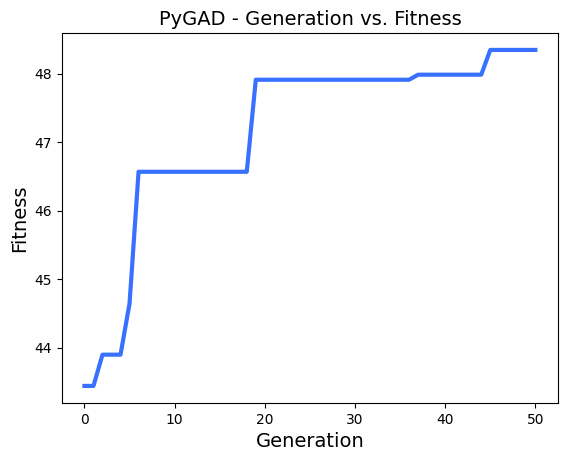

In [3]:
arena = Arena()
cheetah_lab = ClassicNNCheetahLab([17, 10, 6])
evolution = Evolution(cheetah_lab, arena)

parameters = {
    'num_generations': 50, # 10
    'sol_per_pop': 10,
    'num_parents_mating': 4,
    'init_range_low': -2,
    'init_range_high': 5,
    'parent_selection_type': 'sss',
    'keep_parents': 1,
    'crossover_type': 'single_point',
    'mutation_type': 'random',
    'mutation_percent_genes': 10,
}

default_parameters = parameters.copy()

evolution.run_evolution(parameters)
evolution.plot_fitness()

In [1]:
# evolution.simulate_best()

## List of tests:
- Depth/Width comparison - Max Fitness heatmap
    - X-axis - width (number of neurons in one layer)
    - Y-axis - depth (number of layers)
    - *NOTE:* total number of neurons should be aproximately the same.
- Activation function (final activation function is always tahn)
    - logsig
    - tanh
    - relu
- Pickup the best choices altogether and compare if more generations are better or bigger population in each generation. (*NOTE:* number of individuals should stay the same)

# Tests

In [4]:
arena = Arena()
logger = logging.basicConfig(filename='log.log', encoding='utf-8', level=logging.DEBUG) # None
# use logger = None for printing info into terminal 

default_parameters = {
    'num_generations': 10,
    'sol_per_pop': 10,
    'num_parents_mating': 4,
    'init_range_low': -2,
    'init_range_high': 5,
    'parent_selection_type': 'sss',
    'keep_parents': 1,
    'crossover_type': 'single_point',
    'mutation_type': 'random',
    'mutation_percent_genes': 10,
    "logger": logger,
}

test[rins]


### Depth/Width comparison

In [4]:
def evolution_heatmap(x_axis, y_axis, parameters=default_parameters, iterations=5, actv_func=None, steps=100):
    width, depth = x_axis, y_axis

    best_solutions = [([None] * len(depth)) for _ in range(len(width))]
    best_solution_fitness = [([None] * len(depth)) for _ in range(len(width))] # copy empty list with correct shape

    try:
        for x, w in enumerate(width):
            for y, d in enumerate(depth):
                hidden = [w]*d
                cheetah_lab = ClassicNNCheetahLab([17, *hidden, 6], actv_func)
                solution = list()
                fitness = list()

                for _ in range(iterations):
                    evolution = Evolution(cheetah_lab, arena, steps)
                    _ = evolution.run_evolution(parameters)

                    s, f, _ = evolution.get_best_solutions()
                    solution.append(s)
                    fitness.append(f)
                    
                best_solutions[x][y] = solution
                best_solution_fitness[x][y] = fitness
    finally:
        return best_solutions, best_solution_fitness


In [12]:
file_name = "solutions_and_fitness_w2_15_3__d1_6_iter5.pkl"
width = list(range(2, 15, 3)) # list((5,10,15))
depth = list(range(1,6)) # list((1,2,3))
parameters = default_parameters.copy() # not necessary - used only for heatmap title

if os.path.isfile(file_name):
    with open('solutions_and_fitness_w2_15_3__d1_6_iter5.pkl','rb') as f:
        (best_solutions, best_solution_fitness) = pickle.load(f)
else:
    best_solutions, best_solution_fitness = evolution_heatmap(width, depth, iterations=5)

In [13]:
# with open('new_solutions_and_fitness_w2_15_3__d1_6_iter5.pkl','wb') as f:
#     pickle.dump((best_solutions, best_solution_fitness), f)

In [14]:
fitness = np.mean(np.array(best_solution_fitness), axis=2)

df = px.data.medals_wide(indexed=True)
fig = px.imshow(
    fitness.T,
    title="Width/Depth comparison of best individual in {} generations".format(parameters["num_generations"]),
    labels=dict(x="NN width", y="NN depth", color="Fitness"),
    x=list(map(str,width)), 
    y=list(map(str,depth)),
    color_continuous_scale=px.colors.sequential.Viridis,
)
fig.show()

In [39]:
width = list()
depth = list(range(1,6))

parameters = default_parameters.copy()
parameters["num_generations"] = 50

best_solutions, best_solution_fitness = evolution_heatmap(width, depth, iterations=5)

c:\Users\havel\Documents\skola\CUNI - AI INF\predmety\2 Letny semester\Evolucna robotika\evrobot\lib\site-packages\pygad\pygad.py:1074: UserWarning:

Use the 'save_best_solutions' parameter with caution as it may cause memory overflow when either the number of generations or number of genes is large.

----------------------------------------------------------------------
                           PyGAD Lifecycle                           
Step                   Handler                            Output Shape
Fitness Function       _fitness_func()                    (1)      
----------------------------------------------------------------------
Parent Selection       steady_state_selection()           (4, 54)  
Number of Parents: 4
----------------------------------------------------------------------
Crossover              single_point_crossover()           (4, 54)  
----------------------------------------------------------------------
Mutation               random_mutation()       

In [40]:
fitness = np.mean(np.array(best_solution_fitness), axis=2)

df = px.data.medals_wide(indexed=True)
fig = px.imshow(
    fitness.T,
    title="Width/Depth comparison of best individual in {} generations".format(parameters["num_generations"]),
    labels=dict(x="NN width", y="NN depth", color="Fitness"),
    x=list(map(str,width)), 
    y=list(map(str,depth)),
    color_continuous_scale=px.colors.sequential.Viridis,
)
fig.show()

In [42]:
best_cheetah = ClassicNNCheetahLab([17, 5, 6])
genom_length = best_cheetah.get_genom_length()
print("Size of genom: ", genom_length)

Size of genom:  126


## Simulation

In [15]:
fitness = np.array(best_solution_fitness)
solutions = best_solutions

idx = np.unravel_index(np.argmax(fitness), fitness.shape)  # returns a tuple
best = solutions[idx[0]][idx[1]][idx[2]]
w, d, f =  width[idx[0]], depth[idx[1]], None

hidden = [w]*d

cheetah_lab = ClassicNNCheetahLab([17, *hidden, 6], f)
evolution.simulate(
    best,
    cheetah_lab
)


test[rins]


AttributeError: module 'gymnasium.wrappers' has no attribute 'Monitor'

### Activation functions

In [5]:
actv_func = {
    "tanh": np.tanh,
    "relu": np.vectorize(lambda x: np.maximum(0, x)),
    "logsig": None # default
}

In [6]:
width = [2,5,8]
# width = [10]
depth = [1]
 
assert len(width) == 1 or len(depth) == 1, "at least one dimension must have only one value" # Must be 1D for boxplots

parameters = default_parameters.copy()
parameters["num_generations"] = 25 # 50

In [7]:
use_depth = len(width) == 1

if use_depth:
    axis = 0
    label = "depth"
else:
    axis = 1
    label = "width"

all_solutions = list()
pre_df = list()

try:
    for name, func in actv_func.items():
        print("---------- Iteration ---------")
        best_solutions, best_solution_fitness = evolution_heatmap(width, depth, iterations=5, actv_func=func, steps=200)
        all_solutions.append(best_solutions)

        fitness = np.squeeze(np.array(best_solution_fitness), axis=axis)# delete  
        
        for s, fits in zip((depth if use_depth else width), fitness):
            pre_df += [(name, str(s), fit) for fit in fits]

finally:
    df = pd.DataFrame(pre_df, columns=["function", label, "fitness"])


----------------------------------------------------------------------
                           PyGAD Lifecycle                           
Step                   Handler                            Output Shape
Fitness Function       _fitness_func()                    (1)      
----------------------------------------------------------------------
Parent Selection       steady_state_selection()           (4, 54)  
Number of Parents: 4
----------------------------------------------------------------------
Crossover              single_point_crossover()           (4, 54)  
----------------------------------------------------------------------
Mutation               random_mutation()                  (4, 54)  
Mutation Genes: 5
Random Mutation Range: (-1.0, 1.0)
Mutation by Replacement: False
Allow Duplicated Genes: True
----------------------------------------------------------------------
Population Size: (10, 54)
Number of Generations: 50
Initial Population Range: (-2, 5)
Keep Elitism

---------- Iteration ---------


----------------------------------------------------------------------
                           PyGAD Lifecycle                           
Step                   Handler                            Output Shape
Fitness Function       _fitness_func()                    (1)      
----------------------------------------------------------------------
Parent Selection       steady_state_selection()           (4, 54)  
Number of Parents: 4
----------------------------------------------------------------------
Crossover              single_point_crossover()           (4, 54)  
----------------------------------------------------------------------
Mutation               random_mutation()                  (4, 54)  
Mutation Genes: 5
Random Mutation Range: (-1.0, 1.0)
Mutation by Replacement: False
Allow Duplicated Genes: True
----------------------------------------------------------------------
Population Size: (10, 54)
Number of Generations: 50
Initial Population Range: (-2, 5)
Keep Elitism

---------- Iteration ---------


----------------------------------------------------------------------
                           PyGAD Lifecycle                           
Step                   Handler                            Output Shape
Fitness Function       _fitness_func()                    (1)      
----------------------------------------------------------------------
Parent Selection       steady_state_selection()           (4, 54)  
Number of Parents: 4
----------------------------------------------------------------------
Crossover              single_point_crossover()           (4, 54)  
----------------------------------------------------------------------
Mutation               random_mutation()                  (4, 54)  
Mutation Genes: 5
Random Mutation Range: (-1.0, 1.0)
Mutation by Replacement: False
Allow Duplicated Genes: True
----------------------------------------------------------------------
Population Size: (10, 54)
Number of Generations: 50
Initial Population Range: (-2, 5)
Keep Elitism

---------- Iteration ---------


----------------------------------------------------------------------
                           PyGAD Lifecycle                           
Step                   Handler                            Output Shape
Fitness Function       _fitness_func()                    (1)      
----------------------------------------------------------------------
Parent Selection       steady_state_selection()           (4, 54)  
Number of Parents: 4
----------------------------------------------------------------------
Crossover              single_point_crossover()           (4, 54)  
----------------------------------------------------------------------
Mutation               random_mutation()                  (4, 54)  
Mutation Genes: 5
Random Mutation Range: (-1.0, 1.0)
Mutation by Replacement: False
Allow Duplicated Genes: True
----------------------------------------------------------------------
Population Size: (10, 54)
Number of Generations: 50
Initial Population Range: (-2, 5)
Keep Elitism

In [8]:
fig = px.box(df, y="fitness", x=label, color="function", points="all", orientation='v',
             title="Fitness dispersion based on NN depth and activation function of hidden layers")
fig.show()

In [9]:
fig = px.box(df, y="fitness", x="function", points="all", orientation='v',
             title="Fitness dispersion based on activation function in hidden layers ({} = {}, all sizes combined)".format(label, width[0] if use_depth else depth))
fig.show()

In [12]:
para_name = "new_actv_func_df_w2w5w8_d1_iter5_step200"
df.to_csv(para_name+'.csv')
with open(para_name+'.pkl','wb') as f:
    pickle.dump(all_solutions, f)

## Generation/Population Comparison

#### Relu with width 5 and depth 1

In [14]:
def generation_heatmap(popgen, cheetah_lab, parameters=default_parameters, iterations=5, actv_func=None, steps=100):

    best_solutions = [([None] * len(depth)) for _ in range(len(width))]
    best_solution_fitness = [([None] * len(depth)) for _ in range(len(width))] 

    try:
        for i, (p, g) in enumerate(popgen):
            parameters["num_generations"] = g
            parameters["sol_per_pop"] = p

            solution = list()
            fitness = list()

            for _ in range(iterations):
                evolution = Evolution(cheetah_lab, arena, steps)
                _ = evolution.run_evolution(parameters)

                s, f, _ = evolution.get_best_solutions()
                solution.append(s)
                fitness.append(f)
                
            best_solutions[i] = solution
            best_solution_fitness[i] = fitness
            
    finally:
        return best_solutions, best_solution_fitness


In [15]:
cheetah_lab = ClassicNNCheetahLab([17, 5, 6], actv_func["relu"])

popgen = [
    (100,  10),
    ( 50,  20),
    # ( 25,  40),
    # ( 10, 100),
]

solutions_gen, fitness_gen = generation_heatmap(popgen, cheetah_lab, steps=1)

c:\Users\havel\Documents\skola\CUNI - AI INF\predmety\2 Letny semester\Evolucna robotika\evrobot\lib\site-packages\pygad\pygad.py:1074: UserWarning:

Use the 'save_best_solutions' parameter with caution as it may cause memory overflow when either the number of generations or number of genes is large.

----------------------------------------------------------------------
                           PyGAD Lifecycle                           
Step                   Handler                            Output Shape
Fitness Function       _fitness_func()                    (1)        
----------------------------------------------------------------------
Parent Selection       steady_state_selection()           (4, 126)   
Number of Parents: 4
----------------------------------------------------------------------
Crossover              single_point_crossover()           (4, 126)   
----------------------------------------------------------------------
Mutation               random_mutation() 

In [17]:
para_name = "new_popgen_NN17-5-6_pg100-10_50_20_relu_steps1"
with open(para_name+'.pkl','wb') as f:
    pickle.dump((solutions_gen, fitness_gen), f)

In [22]:
predf = list()

for s, fits in zip(popgen, fitness_gen):
    
    predf += [(s[0], s[1], "({}, {})".format(*s), fit) for fit in fits]

df = pd.DataFrame(predf, columns=("population", "generation", "popgen", "fitness"))

fig = px.box(df, y="fitness", x="popgen", points="all", orientation='v',
             title="Fitness dispersion based on population-size and number of genearation ratio".format(label, width[0] if use_depth else depth))
fig.show()

- Test 2 

In [23]:
cheetah_lab = ClassicNNCheetahLab([17, 5 6], actv_func["relu"])

popgen = [
    ( 50,  10),
    ( 25,  20),
    ( 10, 50),
]

solutions_gen, fitness_gen = generation_heatmap(popgen, cheetah_lab, steps=200)

para_name = "popgen_NN17-5-6_pg50-10_25-20_10-50_relu_steps200"
with open(para_name+'.pkl','wb') as f:
    pickle.dump((solutions_gen, fitness_gen), f)

c:\Users\havel\Documents\skola\CUNI - AI INF\predmety\2 Letny semester\Evolucna robotika\evrobot\lib\site-packages\pygad\pygad.py:1074: UserWarning:

Use the 'save_best_solutions' parameter with caution as it may cause memory overflow when either the number of generations or number of genes is large.

----------------------------------------------------------------------
                           PyGAD Lifecycle                           
Step                   Handler                            Output Shape
Fitness Function       _fitness_func()                    (1)        
----------------------------------------------------------------------
Parent Selection       steady_state_selection()           (4, 126)   
Number of Parents: 4
----------------------------------------------------------------------
Crossover              single_point_crossover()           (4, 126)   
----------------------------------------------------------------------
Mutation               random_mutation() 

In [24]:
predf = list()

for s, fits in zip(popgen, fitness_gen):
    
    predf += [(s[0], s[1], "({}, {})".format(*s), fit) for fit in fits]

df = pd.DataFrame(predf, columns=("population", "generation", "popgen", "fitness"))

fig = px.box(df, y="fitness", x="popgen", points="all", orientation='v',
             title="Fitness dispersion based on population-size and number of genearation ratio".format(label, width[0] if use_depth else depth))
fig.show()

- Test 3

In [26]:
cheetah_lab = ClassicNNCheetahLab([17, 5, 6], actv_func["tanh"])

popgen = [
    (100,   10),
    ( 50,   20),
    ( 10,  100),
]

solutions_gen, fitness_gen = generation_heatmap(popgen, cheetah_lab, steps=250, iterations=10)

para_name = "popgen_NN17-5-6_pg100-10_50-20_10-100_tanh_steps250"
with open(para_name+'.pkl','wb') as f:
    pickle.dump((solutions_gen, fitness_gen), f)

c:\Users\havel\Documents\skola\CUNI - AI INF\predmety\2 Letny semester\Evolucna robotika\evrobot\lib\site-packages\pygad\pygad.py:1074: UserWarning:

Use the 'save_best_solutions' parameter with caution as it may cause memory overflow when either the number of generations or number of genes is large.

----------------------------------------------------------------------
                           PyGAD Lifecycle                           
Step                   Handler                            Output Shape
Fitness Function       _fitness_func()                    (1)        
----------------------------------------------------------------------
Parent Selection       steady_state_selection()           (4, 126)   
Number of Parents: 4
----------------------------------------------------------------------
Crossover              single_point_crossover()           (4, 126)   
----------------------------------------------------------------------
Mutation               random_mutation() 

In [27]:
predf = list()

for s, fits in zip(popgen, fitness_gen):
    
    predf += [(s[0], s[1], "({}, {})".format(*s), fit) for fit in fits]

df = pd.DataFrame(predf, columns=("population", "generation", "popgen", "fitness"))

fig = px.box(df, y="fitness", x="popgen", points="all", orientation='v',
             title="Fitness dispersion based on population-size and number of genearation ratio".format(label, width[0] if use_depth else depth))
fig.show()